# Tutorial on Helpers for Model Fitting

This tutorial discusses helper codes you can use for model fitting with tellurium. The tutorial gives practical examples of to use these codes in a model fitting workflow.

For those who want to get right to the quick start section, the follwing information can be scipped over and it only required for advanced users

The utilities are in 3 python modules (files):

- named_timeseries defines a NamedTimeseries type that allows you to manipulate tabular data that has a time axis. A NamedTimeseries can be initialized from a comma separated variable (CSV) file.
- model_fitter defines a ModelFitter type that encapsulates the basics of fitting parameters to a NamedTimeseries. You can simulate the fitted model, and the result is a NamedTimeseries.
- timeseries_plotter plots one or two NamedTimeseries. You can have all variables on a single subplot or have separate subplots for each variable.

You should open this notebook from ``teUtils``, then open the folder ``notebooks`` to find this notebook.

## Quick Start

We need to first import the teUtils python package. You can either use the 'from' symtax shown below or the simpler 'import' syntax, eg import teUtils
The simpler syntax might be more convenient if you want to use the other functions in the teUtils package because you can use the console help system
to quickly identifiy the different packages in teUtils. Just remember,  when using the simpler syntax use the prefix 'modelFitter.ModeFitter'
when creating the fitter object. Note that 'modelFitter' is the package name and 'ModelFitter' with a capital M, is the function that will create the fitter object.


In [1]:
# Basic imports
from teUtils.modelFitter import ModelFitter
%matplotlib inline

Let's first define our model. This is a five-step pathway with five unknown parameterss, k1 to k6



In [2]:
# Model of a linear pathway
ANTIMONY_MODEL = """ 
# Reactions   
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S4; k3*S3
    J4: S4 -> S5; k4*S4
    J5: S5 -> S6; k5*S5;
# Species initializations
    S1 = 10;
    S2 = 0;
    S3 = 0;
    S4 = 0;
    S5 = 0;
    S6 = 0;
    k1 = 1;
    k2 = 2;
    k3 = 3;
    k4 = 4;
    k5 = 5;
"""

Next we actually fit the model to some data. This just requies two lines:

1. Create the fitting object: This requires the model (antimony or roadrunner), the data to fit the model and what parameters you want to fit.
2. The second line causes the fitting to take place.

The data file is just a normal CSV file, where the first column is time and the remaining columns are what ever you have measured.
In this case the data file has all five-step species recorded in time, hence it has one column for utime and six columns for the siz species.

By default, the fitter will use all the data it finds in the data file unless specified otherwise.


In [3]:
# Fit parameters to ts1
fitter = ModelFitter(ANTIMONY_MODEL, "tst_data.txt", ["k1", "k2", "k3", "k4", "k5"])
fitter.fitModel()

If the fit was successful, ?????
you can ask the fitter for information on what the results were using the reportFit call:


In [4]:
# Provide fit details
print(fitter.reportFit())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 180
    # variables        = 5
    chi-square         = 73.2546170
    reduced chi-square = 0.41859781
    Akaike info crit   = -151.822803
    Bayesian info crit = -135.858019
[[Variables]]
    k1:  0.95579053 +/- 0.03816186 (3.99%) (init = 5)
    k2:  2.24079567 +/- 0.19847112 (8.86%) (init = 5)
    k3:  2.96763525 +/- 0.35879852 (12.09%) (init = 5)
    k4:  3.07652723 +/- 0.39858904 (12.96%) (init = 5)
    k5:  5.90802238 +/- 1.43620318 (24.31%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(k4, k5) = -0.248
    C(k3, k4) = -0.226
    C(k2, k3) = -0.218
    C(k3, k5) = -0.211
    C(k2, k4) = -0.189
    C(k1, k2) = -0.179
    C(k2, k5) = -0.178
    C(k1, k3) = -0.147
    C(k1, k5) = -0.144
    C(k1, k4) = -0.141


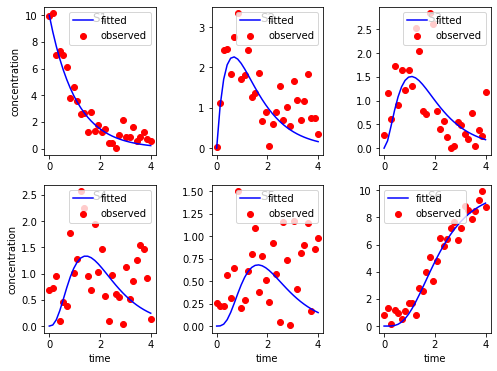

In [5]:
# Plot the fitl
fitter.plotFitAll(numRow=2, numCol=3)

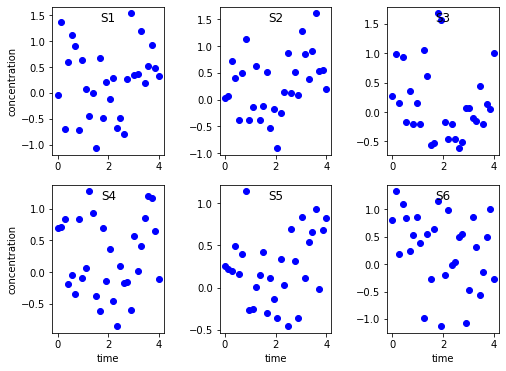

In [6]:
# Plot residuals
fitter.plotResiduals(numRow=2, numCol=3)

In [7]:
# Get estimates of parameter variance by using bootstrapping
fitter.bootstrap(numIteration=2000, reportInterval=500)
print(fitter.getFittedParameterStds())

bootstrap completed 500 iterations
bootstrap completed 1000 iterations
bootstrap completed 1500 iterations
bootstrap completed 2000 iterations
[0.020447947493430145, 0.09051802528712986, 0.20428878563491876, 0.1814074114424244, 0.5846450332790609]


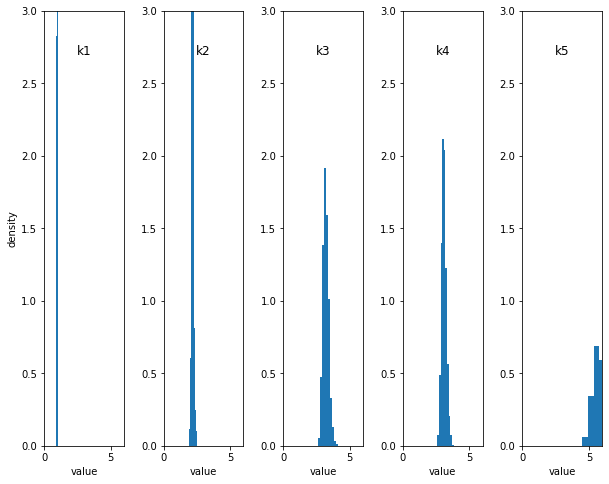

In [8]:
# Look at the distribution of the parameter fits.
fitter.plotParameterHistograms(figsize=(10,8), ylim=[0, 3], xlim=[0, 6])

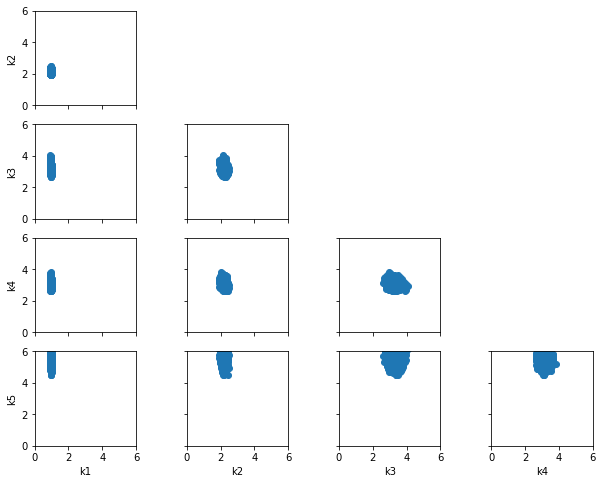

In [9]:
# Look at interactions between parameter estimates
fitter.plotParameterEstimatePairs(figsize=(10,8), ylim=[0, 6], xlim=[0, 6])

## Detailed Tutorial

In [12]:
# Import the modules needed.
import numpy as np
import tellurium as te

from teUtils.namedTimeseries import NamedTimeseries, TIME
from teUtils.timeseriesPlotter import TimeseriesPlotter
from teUtils.modelFitter import ModelFitter


## Manipulating Tabular Data
Tables are a great way to describe data. Tables are a collection of values organized into rows and columns. Typically, the columns have names. Common operations on tables are:

- Create a table from a file
- Create a new table from a subset of rows and/or columns
- Create new columns and/rows by performing addition, subtaction, and other operations on table rows and columns.

Many systems provide table representations. Spreadsheets are widely used. In the R language, a dataframe is a table. In python, the pandas package provides a python version of dataframes.

Pandas is very powerful, but it is slow. numpy provides arrays and matrices, but these lack the convenience of column names. In addition, the variables we analyze are collected at the same timepoints, and so it's important to associate these timepoints with the variable values.

``NamedTimeseries`` is a thin layer on top of numpy ``ndarray`` that provides an efficient table abstraction. Efficiency is a particular concern for model fitting since fitting can be very numerically intensive.

Let's start by creating a ``NamedTimeseries`` from the file ``tst_data.txt``. In python, an object is created from a constructor that is the class name followed by arguments. There are several constructors for ``NamedTimeseries``.

In [13]:
ts1 = NamedTimeseries(csvPath="tst_data.txt")  # Construct from a file
print(ts1)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328
0.8276   3.8228  3.3404  1.2123  1.7698  1.5003  1.0749
0.9655   4.6108  1.7214  1.6500  1.0085  0.1968  1.7338
1.1034   3.5587  1.8193  1.2961  1.2860  0.2940  1.6741
1.2414   2.6042  2.4365  2.5273  2.5676  0.6165  0.7777
1.3793   2.6670  1.2691  2.0335  2.2550  0.8024  2.8139
1.5172   1.2771  1.3716  0.7828  0.9520  1.0949  2.5456
1.6552   2.7374  1.8548  0.7135  0.6904  0.3783  4.0125
1.7931   1.3202  0.6774  2.8310  1.9432  0.7798  5.0623
1.9310   1.7973  0.8914  2.6131  1.0384  0.5163  3.3272
2.0690   1.2621  0.0490  0.7817  1.4685  0.2633 

There are 7 columns (including "time") and 30 rows. All ``NamedTimeseries`` have a "time" column. In fact, the python variable ``TIME`` can be used to reference this column.

We reference rows by their "index", their count from 0. In fact, we can make a new ``NamedTimeseries`` that consists of a subset of the rows.

In [14]:
# Get the first row
print(ts1[1])

            S1      S2      S3      S4      S5    S6
time                                                
0.1379  10.143  1.1243  1.1493  0.7275  0.2183  1.33


In [15]:
# Get rows 1, 3, 5
print(ts1[[1, 3, 5]])

             S1      S2      S3      S4      S5      S6
time                                                   
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


In [16]:
# Get rows 1 through 5
# This is a slice; you specify the first row you want and where the slice stops
ts2 = ts1[1:6]
print(ts2)

             S1      S2      S3      S4      S5      S6
time                                                   
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


We can also select columns. A column select produces a ``numpy`` ``ndarray``, not at ``NamedArray``. This is done so that we can manipulate column selections using the powerful numpy facilities.

In [17]:
ts2["S1"]  # Column S1 in ts2

array([10.143 ,  6.9845,  7.3271,  7.0252,  6.084 ])

To get the numpy array for a list of columns, we give the list.

In [18]:
ts2[["S1", "S2"]]

array([[10.143 ,  1.1243],
       [ 6.9845,  2.426 ],
       [ 7.3271,  2.4685],
       [ 7.0252,  1.8382],
       [ 6.084 ,  2.7645]])

To get a **new timeseries** that just has "S1", you use ``subsetColumns``.

In [19]:
ts2a = ts2.subsetColumns("S1")
print(ts2a)

             S1
time           
0.1379  10.1430
0.2759   6.9845
0.4138   7.3271
0.5517   7.0252
0.6897   6.0840


In [20]:
# Create a timeseries from ts2 with just S1, S2
print(ts2.subsetColumns(["S1", "S2"]))

             S1      S2
time                   
0.1379  10.1430  1.1243
0.2759   6.9845  2.4260
0.4138   7.3271  2.4685
0.5517   7.0252  1.8382
0.6897   6.0840  2.7645


We can add columns to the timeseries. Here, we add a column with a constant value of 1.

In [21]:
ts2["constant_1"] = 1
print(ts2)

             S1      S2      S3      S4      S5      S6  constant_1
time                                                               
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300         1.0
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860         1.0
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456         1.0
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807         1.0
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328         1.0


We can also do calculations and create new columns with the results.

In [22]:
ts2["New_Calculation"] = ts2["S1"] + np.multiply(ts2["S2"], ts2[TIME])
ts2["Other_Calculation"] = ts2["S1"] + 10*np.multiply(ts2["S2"], ts2[TIME])
print(ts2)

             S1      S2      S3      S4      S5      S6  constant_1  \
time                                                                  
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300         1.0   
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860         1.0   
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456         1.0   
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807         1.0   
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328         1.0   

        New_Calculation  Other_Calculation  
time                                        
0.1379        10.298041          11.693410  
0.2759         7.653833          13.677834  
0.4138         8.348565          17.541753  
0.5517         8.039335          17.166549  
0.6897         7.990676          25.150756  


In [23]:
# Let's get rid of Other_Calculation
del ts2["Other_Calculation"]
print(ts2)

             S1      S2      S3      S4      S5      S6  constant_1  \
time                                                                  
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300         1.0   
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860         1.0   
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456         1.0   
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807         1.0   
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328         1.0   

        New_Calculation  
time                     
0.1379        10.298041  
0.2759         7.653833  
0.4138         8.348565  
0.5517         8.039335  
0.6897         7.990676  


We can combine the rows and columns of a ``NamedTimeseries`` to make a new ``NamedTimeseries``.

In [24]:
ts3 = ts2.subsetColumns(["S1", "S2"])
ts4 = ts2.subsetColumns("S3")
ts5 = ts2.subsetColumns("New_Calculation")
ts6 = ts3.concatenateColumns([ts4, ts5])  # Has S1, S2, S3, New_Calculation"
print(ts6)

             S1      S2      S3  New_Calculation
time                                            
0.1379  10.1430  1.1243  1.1493        10.298041
0.2759   6.9845  2.4260  0.6174         7.653833
0.4138   7.3271  2.4685  1.7287         8.348565
0.5517   7.0252  1.8382  0.9091         8.039335
0.6897   6.0840  2.7645  1.6500         7.990676


In [25]:
ts7 = ts1[:2]
ts8 = ts1[2:4]
ts9 = ts1[4:6]
ts10 = ts7.concatenateRows([ts8, ts9])  # First 6 rows of ts1
print(ts10)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328


In [26]:
# Save the result in a file
ts2.to_csv("new_data.csv")

In [27]:
# To see the file, we run a command in the operating system shell. The following works in Unix and Mac.
!cat new_data.csv

time,S1,S2,S3,S4,S5,S6,constant_1,New_Calculation
0.1379,10.143,1.1243,1.1493,0.7275,0.2183,1.33,1.0,10.29804097
0.2759,6.9845,2.426,0.6174,0.9473,0.2214,0.186,1.0,7.6538334
0.4138,7.3271,2.4685,1.7287,0.1039,0.566,1.1456,1.0,8.3485653
0.5517,7.0252,1.8382,0.9091,0.457,0.3135,0.9807,1.0,8.03933494
0.6897,6.084,2.7645,1.65,0.3831,0.6469,0.5328,1.0,7.99067565


## Plotting Tabular Data
We provide 4 types of plots with user controllable options for the plots. The plots are:

1. Plot all variables of one table on a single plot.
1. Plot all variables of one table in one plot and all variables of second plot
1. Plot each variable of a table in a separate plot
1.  Plot each variable of two tables in the same plot

In [28]:
# Create the plotter object
plotter = TimeseriesPlotter()

In [31]:
# To see the plotting options...
?plotter.plotHistograms

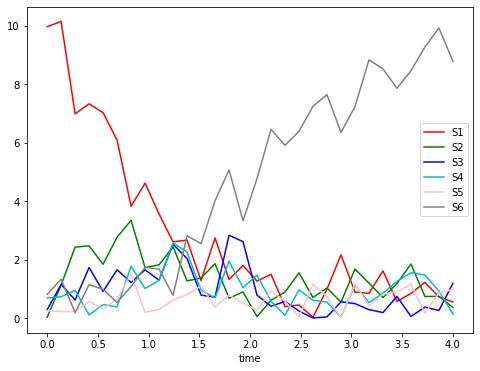

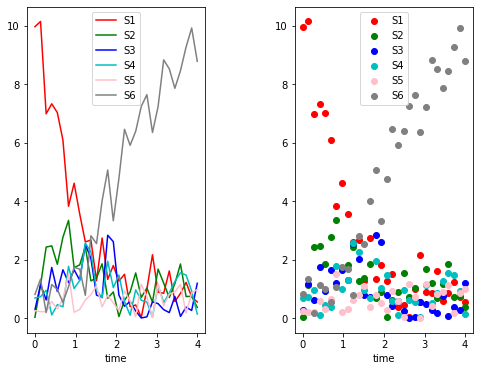

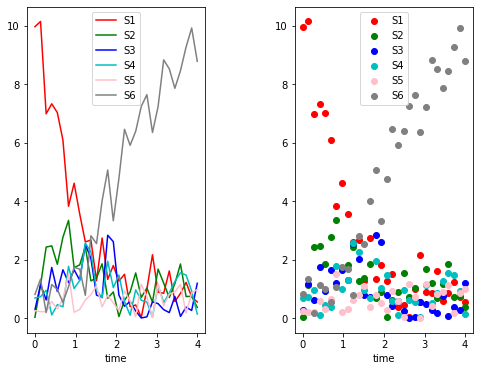

In [32]:
# Case 1: Plot all variables of a single table on a single plot
plotter.plotTimeMultiple(ts1)
plotter.plotTimeMultiple(ts1, timeseries2=ts1, marker2="o")
plotter.plotTimeMultiple(ts1, timeseries2=ts1, marker2="o", numCol=1, numRow=1)

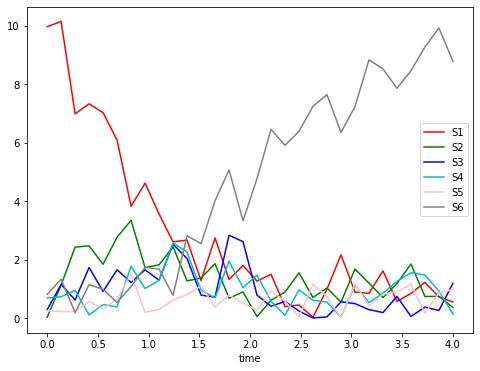

In [33]:
# We can also plot a subset of the variables in a single plot
plotter.plotTimeMultiple(ts1, columns=["S1", "S6"])

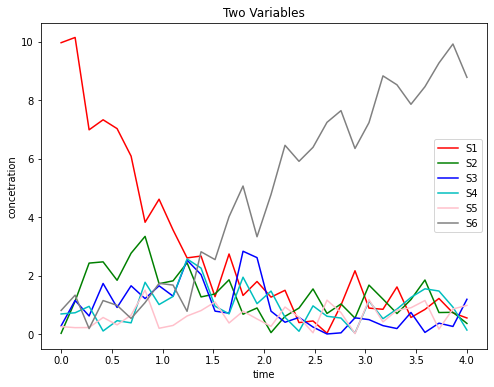

In [34]:
# Add to the plot with options
plotter.plotTimeMultiple(ts1, columns=["S1", "S6"], ylabel="concetration", title="Two Variables")

In [35]:
# Create a second table for comparisons. We can access all non-time variables using the property colnames.
ts4 = ts1.copy()  # Create a copy of the timeseries
ts4[ts4.colnames] = 5*np.cos(ts4[ts4.colnames]) + 2*ts4[ts4.colnames]

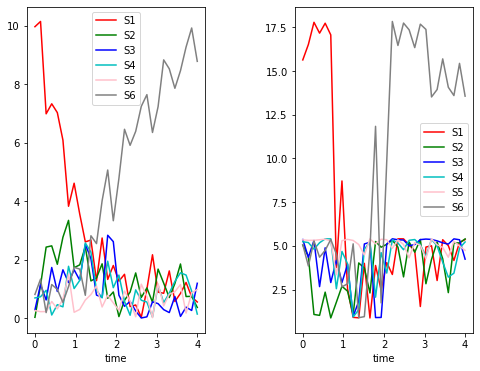

In [36]:
# Case 2: Plot two multiple variable plots, side-by-side
plotter.plotTimeMultiple(ts1, timeseries2=ts4)

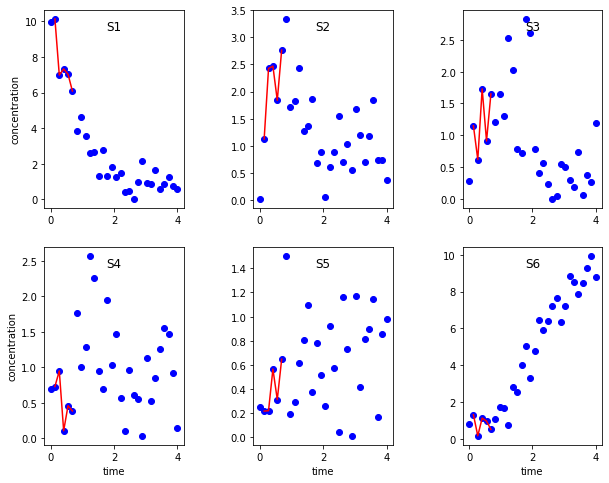

In [37]:
# Case 3: Separate plot for each variable of a single table
plotter.plotTimeSingle(ts1, numRow=2, numCol=3, timeseries2=ts2,
                      figsize=(10,8), marker1="o")

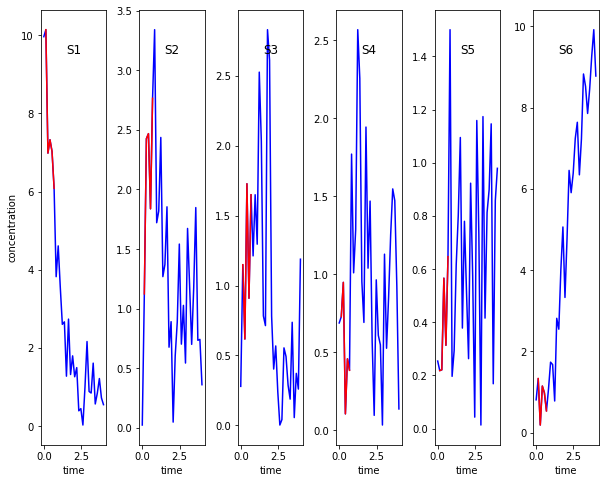

In [38]:
# Case 4: Separate plot for each variable for two tables
plotter.plotTimeSingle(ts1, timeseries2=ts2, figsize=(10, 8))

## Fitting Parameters of a Model
Kinetics models frequently have unknown constants that need to be estimated. This process of estimation is called model fitting, or just fitting. Fitting involves running multiple simulations with different values of parameters to find values that result in a good match between simulated and measured species concentrations.

In [39]:
ANTIMONY_MODEL = """ 
# Reactions   
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S4; k3*S3
    J4: S4 -> S5; k4*S4
    J5: S5 -> S6; k5*S5;
# Species initializations
    S1 = 10;
    S2 = 0;
    S3 = 0;
    S4 = 0;
    S5 = 0;
    S6 = 0;
    k1 = 1;
    k2 = 2;
    k3 = 3;
    k4 = 4;
    k5 = 5;
"""

This model has the parameters ``k1, k2, k3, k4, k5``, the kinetics constants for their respective reactions. In this case, we know the true value of the parameters, which are specified at the bottom of the model. This knowledge provides a way to explore the effectiveness of model fitting.

This model is a linear pathway where mass moves from species ``S1`` to ``S6`` over time. The rate at which this happens depends on the kinetics constants.

Let's see how well we can fit this model to the ``ts1`` data described in the first section.

In [40]:
print(ts1)

             S1      S2      S3      S4      S5      S6
time                                                   
0.0000   9.9639  0.0245  0.2788  0.6869  0.2543  0.8066
0.1379  10.1430  1.1243  1.1493  0.7275  0.2183  1.3300
0.2759   6.9845  2.4260  0.6174  0.9473  0.2214  0.1860
0.4138   7.3271  2.4685  1.7287  0.1039  0.5660  1.1456
0.5517   7.0252  1.8382  0.9091  0.4570  0.3135  0.9807
0.6897   6.0840  2.7645  1.6500  0.3831  0.6469  0.5328
0.8276   3.8228  3.3404  1.2123  1.7698  1.5003  1.0749
0.9655   4.6108  1.7214  1.6500  1.0085  0.1968  1.7338
1.1034   3.5587  1.8193  1.2961  1.2860  0.2940  1.6741
1.2414   2.6042  2.4365  2.5273  2.5676  0.6165  0.7777
1.3793   2.6670  1.2691  2.0335  2.2550  0.8024  2.8139
1.5172   1.2771  1.3716  0.7828  0.9520  1.0949  2.5456
1.6552   2.7374  1.8548  0.7135  0.6904  0.3783  4.0125
1.7931   1.3202  0.6774  2.8310  1.9432  0.7798  5.0623
1.9310   1.7973  0.8914  2.6131  1.0384  0.5163  3.3272
2.0690   1.2621  0.0490  0.7817  1.4685  0.2633 

The fitting data has values for each of the six floating species. Model fitting works iteratively varying the values of the parameters, simulating the model with these parameters, and then evaluating how close the simulation is to the fitting data.

So, to do a fit, we must specify:

1. The model to fit
1. The fitting data
1. The parameters to estimate

To elaborate on point (3), often models contain some parameters whose values are known and others that aren't.

The class ``ModelFitter`` is used to do fitting. The constructor must specify all 3 items above. If parameters is None, then no fitting is done.

In [41]:
# Run the model using the parameter values in the model. There is no fitting.
base_fitter = ModelFitter(ANTIMONY_MODEL, ts1, None)

To fit a model, we use the ``fitModel`` method. We can then see the optimized residual variance and the values of the model parameters.

In [42]:
base_fitter.fitModel()

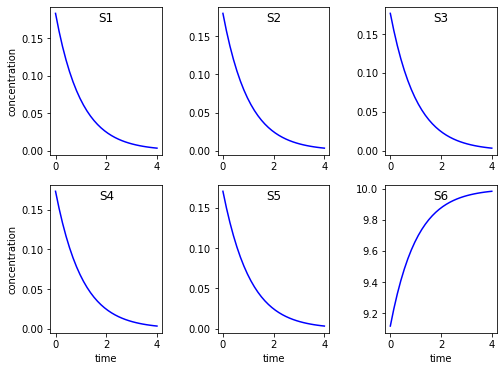

In [43]:
# The model without fitting any parameters
ts_base = NamedTimeseries(namedArray=base_fitter.roadrunnerModel.simulate(0, 4, 30))
plotter.plotTimeSingle(ts_base, numRow=2)

This is a bit crowded for detailed comparisons. So, we make comparisons between each variable.

In our running example, the values of parameters in the original model are their true value. Ideally, we want to achieve a variance close to this. We create a new fitter object since we still want to have access to the unchanged model that we started with.

In [44]:
parameterNames = ["k%d" % i for i in range(1, 6)]
fitter = ModelFitter(ANTIMONY_MODEL, ts1, parameterNames)
fitter.fitModel()
print("residual variance of the fitted model: %3.2f" % np.var(fitter.residualsTS.flatten()))
print("Values of fitted parameters: %s" % str(fitter.getFittedParameters()))

residual variance of the fitted model: 0.35
Values of fitted parameters: [0.9557905306280073, 2.2407956722215316, 2.9676352463919575, 3.0765272300850044, 5.908022375414444]


Now let's compare the fitted model with the data.

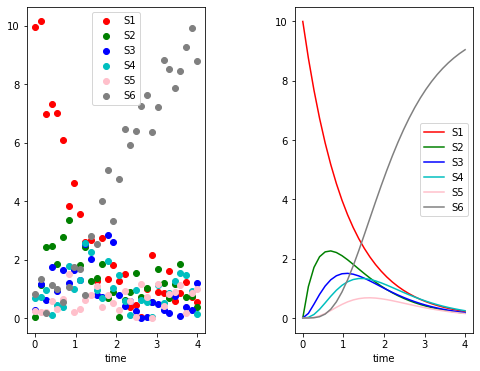

In [45]:
fittedModel = fitter.roadrunnerModel
fittedModel.reset()
fittedTS = NamedTimeseries(namedArray=fittedModel.simulate(ts1.start, ts1.end, len(ts1)))
plotter.plotTimeMultiple(ts1, timeseries2=fittedTS, marker1="o")

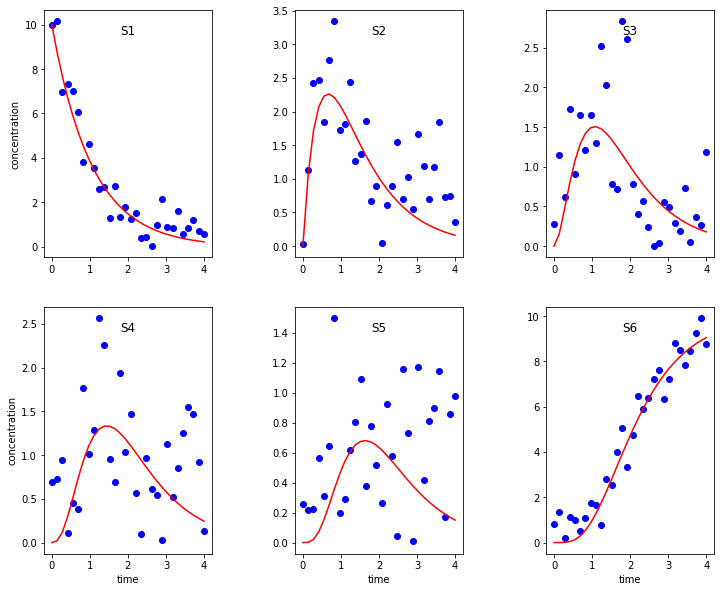

In [46]:
plotter.plotTimeSingle(ts1, timeseries2=fittedTS, numRow=2, numCol=3, figsize=(12, 10), marker1="o")

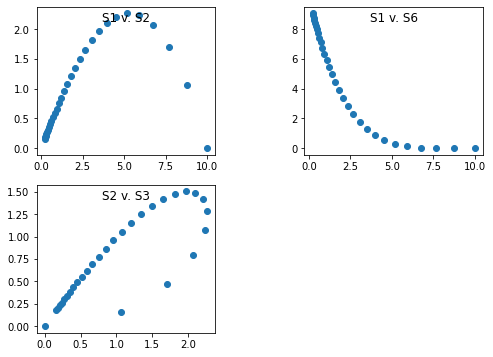

In [47]:
# Plot pairs of values
plotter.plotValuePairs(fittedTS, pairs=[("S1", "S2"), ("S1", "S6"), ("S2", "S3")], numCol=2)

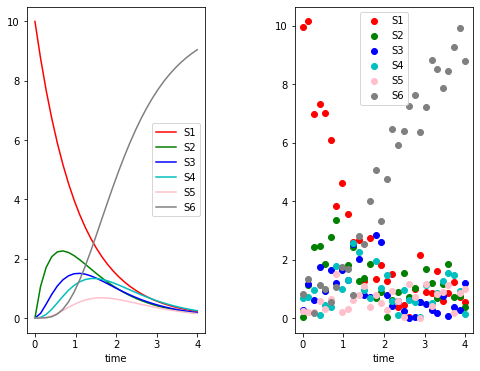

In [48]:
fitter.plotFitAll(numCol=1, numRow=1, isMultiple=True)

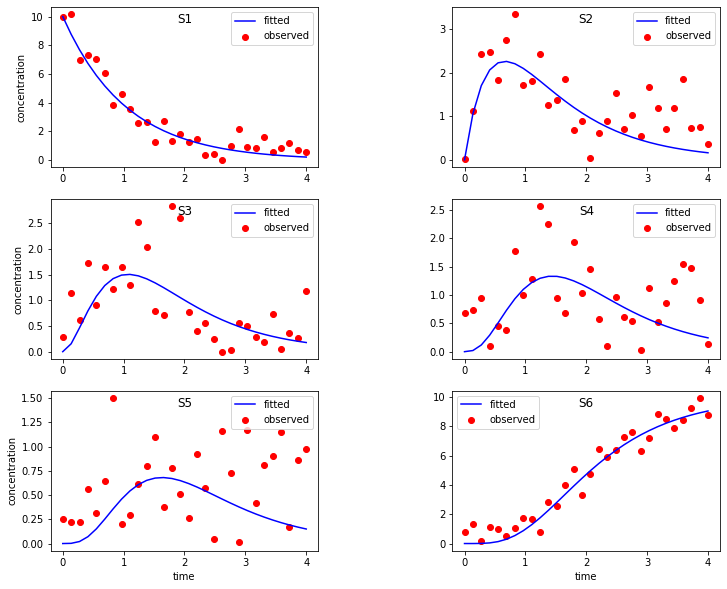

In [49]:
fitter.plotFitAll(numRow=2, numCol=2, figsize=(12, 10))